## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("ha_1.csv")

X = df[["age", "chol"]]
y = df["diagnosis"]

log_reg = LogisticRegression()
log_reg.fit(X, y)

b0 = log_reg.intercept_[0]
b_age = log_reg.coef_[0][0]
b_chol = log_reg.coef_[0][1]

# Age we care about
age_value = 55

#  probability = 0.50
logit_50 = np.log(0.5 / (1 - 0.5))  # This equals 0
chol_50 = (logit_50 - b0 - b_age * age_value) / b_chol

# probability = 0.90
logit_90 = np.log(0.9 / 0.1)
chol_90 = (logit_90 - b0 - b_age * age_value) / b_chol

print("Chol for model to predict HEART DISEASE (p=0.50):", round(chol_50, 2))
print("Chol for doctors to estimate 90% chance (p=0.90):", round(chol_90, 2))


Chol for model to predict HEART DISEASE (p=0.50): 367.87
Chol for doctors to estimate 90% chance (p=0.90): 1587.72


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X, y)

# Extract means, priors, and covariance inverse
mu0 = lda.means_[0]
mu1 = lda.means_[1]
pi0 = lda.priors_[0]
pi1 = lda.priors_[1]
Sigma_inv = np.linalg.inv(lda.covariance_)

# LDA linear boundary components
coef = Sigma_inv @ (mu1 - mu0)
intercept = -0.5 * ((mu1 + mu0).T @ coef) + np.log(pi1 / pi0)

# Solve for cholesterol at age = 55
age_val = 55

chol_50 = -(coef[0] * age_val + intercept) / coef[1]
logit_90 = np.log(0.9 / 0.1)
chol_90 = (logit_90 - coef[0] * age_val - intercept) / coef[1]

print(f"Cholesterol threshold for p=0.50: {chol_50:.2f}")
print(f"Cholesterol threshold for p=0.90: {chol_90:.2f}")


Cholesterol threshold for p=0.50: 366.83
Cholesterol threshold for p=0.90: 1582.52


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [13]:
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV



X = df[['age', 'chol']]
y = df['diagnosis']

param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100]}

svc_pipeline = Pipeline([
    ("standardize", StandardScaler()),
    ("svc", SVC(kernel="linear", probability=True))
])

svc_pipeline_grid = GridSearchCV(svc_pipeline, param_grid, cv=5)
svc_pipeline_grid.fit(X, y)

svc_pipeline_best = svc_pipeline_grid.best_estimator_
svc_model_best = svc_pipeline_best.named_steps["svc"]

svc_age_coef = svc_model_best.coef_[0][0]
svc_chol_coef = svc_model_best.coef_[0][1]
svc_intercept = svc_model_best.intercept_[0]

scaler = svc_pipeline_best.named_steps["standardize"]

df["age_std"] = scaler.transform(df[["age", "chol"]])[:,0]
df["chol_std"] = scaler.transform(df[["age", "chol"]])[:,1]

svc_predictions = svc_pipeline_best.predict(X)
svc_probs = svc_pipeline_best.predict_proba(X)[:, 1]

svc_scores = svc_intercept + svc_age_coef * df['age_std'] + svc_chol_coef * df['chol_std']

df["svc_prediction"] = svc_predictions
df["svc_prob"] = svc_probs
df["svc_score"] = svc_scores

# Solve for required cholesterol for age=55 (decision boundary = 0)

age_val = 55

# Standardize the age value
age_std_val = (age_val - scaler.mean_[0]) / np.sqrt(scaler.var_[0])

# Solve the linear decision equation:
# svc_intercept + svc_age_coef * age_std + svc_chol_coef * chol_std = 0
chol_std_val = -(svc_intercept + svc_age_coef * age_std_val) / svc_chol_coef

# Convert standardized cholesterol back to original scale
chol_required = chol_std_val * np.sqrt(scaler.var_[1]) + scaler.mean_[1]

chol_required



np.float64(312.75313016443647)

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [20]:
# Logistic Regression coefficients
logistic_age_coef = log_reg.coef_[0][0]
logistic_chol_coef = log_reg.coef_[0][1]
logistic_intercept = log_reg.intercept_[0]

# LDA coefficients
lda_age_coef = lda.coef_[0][0]
lda_chol_coef = lda.coef_[0][1]
lda_intercept = lda.intercept_[0]

# SVC coefficients (you already had these)
svc_age_coef = svc_model_best.coef_[0][0]
svc_chol_coef = svc_model_best.coef_[0][1]
svc_intercept = svc_model_best.intercept_[0]


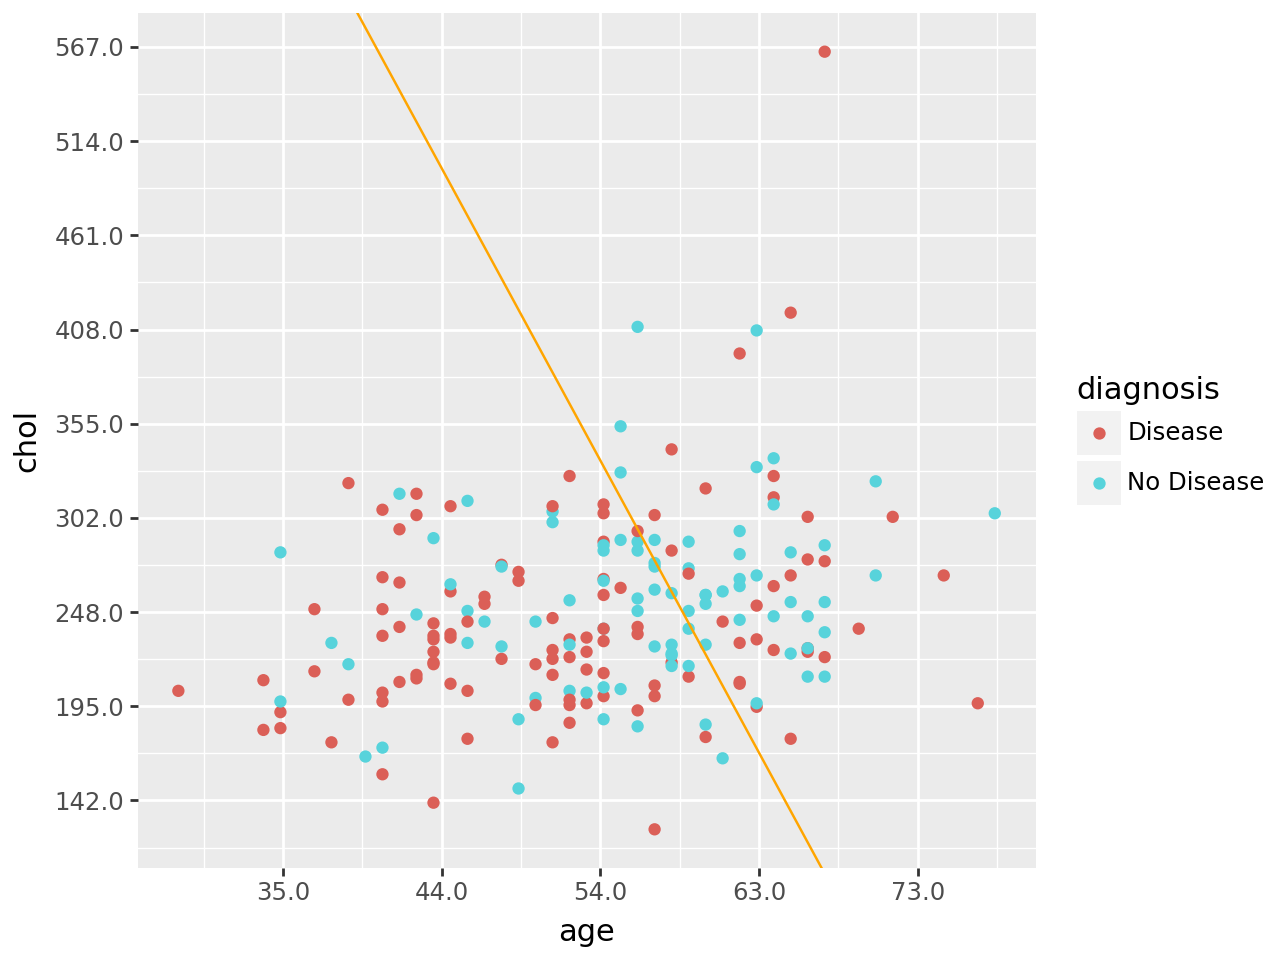

In [16]:
from plotnine import *

(
    ggplot(df, aes(x="age_std", y="chol_std", color="diagnosis"))
    + geom_point()

    # Logistic boundary
    + geom_abline(
        intercept = -logistic_intercept / logistic_chol_coef,
        slope = -logistic_age_coef / logistic_chol_coef,
        color = "purple"
    )

    # LDA boundary
    + geom_abline(
        intercept = -lda_intercept / lda_chol_coef,
        slope = -lda_age_coef / lda_chol_coef,
        color = "blue"
    )

    # SVC boundary (linear kernel)
    + geom_abline(
        intercept = -svc_intercept / svc_chol_coef,
        slope = -svc_age_coef / svc_chol_coef,
        color = "orange"
    )

    # Convert x-axis ticks back to AGE
    + scale_x_continuous(
        breaks = np.arange(-2, 3),
        labels = np.round(df["age"].mean() + df["age"].std() * np.arange(-2, 3), 0)
    )

    # Convert y-axis ticks back to CHOLESTEROL
    + scale_y_continuous(
        breaks = np.arange(-2, 7),
        labels = np.round(df["chol"].mean() + df["chol"].std() * np.arange(-2, 7), 0)
    )

    + labs(x="age", y="chol")
)


In [17]:
logistic_age_coef, logistic_chol_coef, logistic_intercept


(np.float64(0.04686330613037214),
 np.float64(0.0018012385190290258),
 np.float64(-3.240112258859206))

In [18]:
lda_age_coef, lda_chol_coef, lda_intercept


(np.float64(0.04655743553694484),
 np.float64(0.0017896671039291314),
 np.float64(-3.2196776604068784))